In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, absolute_import
import sys
sys.path.append('MO-ASMO/src/')
import numpy as np
import sampling
import gp
import NSGA2
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from os import path
import seaborn as sn
import pickle
import smt
from sklearn import preprocessing
import random
import re
from sklearn.metrics import mean_squared_error
import cmocean
import os
import hydroeval as he

In [3]:
# 
init_iteration = 0 # 5 

# define the number of parameters in each updated run
N_resample = 20

location = 'pe_basin'

num_init_sampling = 200

In [4]:
# define hyper parameters
pop = 100
gen = 100
crossover_rate = 0.9
mu = 20
mum = 20


In [5]:
# basin selected
basin_sel = 'salcha' #'beaver'#'salcha'#'talkeetna'#'kenai' # 'kuparuk'

# evaluation metric
evaluate_metric=['kge_daily','swe_metric']#['kge_daily','mape_max_swe']
nOutput = len(evaluate_metric)

In [6]:
metric_list_0 = 'data/sm_metric_Step2/'
namelist_file = 'data/lnd_in'
basepftfile = 'data/clm50_params.c210607.nc'
source_dir = 'data/'

In [7]:
#baseline

baseline_dir = 'workflow/surrogate_model/metrics/baseline/'
metric_baseline = pd.DataFrame()
swe_metric_b_sum = pd.DataFrame([])
flow_metric_b_sum = pd.DataFrame([])
for basin in [basin_sel]: #['kuparuk','kenai', 'talkeetna', 'salcha', 'beaver']:
    
    flow_metric_b = pd.read_csv(baseline_dir + 'metric.flow.hs_ds_pe_OM_4km_baseline_%s.csv'%(basin), header=None, index_col=[0])
    flow_metric_b.columns=[basin]
    flow_metric_b_sum = pd.concat([flow_metric_b_sum,flow_metric_b.T])
    swe_metric_b = pd.read_csv(baseline_dir + 'metric.swe.hs_ds_pe_OM_4km_baseline_%s.csv'%(basin), index_col=[0])
    swe_metric_cal = np.sqrt(pow(swe_metric_b,2).sum(axis=1))
    swe_metric_b_sum = pd.concat([swe_metric_b_sum,swe_metric_cal])


In [8]:
metric_baseline_mean = pd.DataFrame([[flow_metric_b_sum.mean()[0]],[swe_metric_b_sum.mean()[0]]],index=evaluate_metric, columns=['baseline'])
# calculate the objective function
metric_baseline_mean_norm = metric_baseline_mean.copy()
metric_baseline_mean_norm.loc['kge_daily','baseline'] = 1 - metric_baseline_mean_norm.loc['kge_daily','baseline']
metric_baseline_mean_norm = metric_baseline_mean_norm.dropna()
metric_baseline_mean_norm

,baseline
kge_daily,0.564060
swe_metric,0.615361


In [9]:
# update metric list
evaluate_metric=metric_baseline_mean_norm.index.values
nOutput = len(evaluate_metric)

In [37]:
param_df = pd.DataFrame([])
job_id_list = np.array([])

job_id_file = source_dir + 'workflow_Step2/pe_basin_%s.main_run.txt'%(iter_)
param_pertubed_file = source_dir + 'workflow_Step2/pe_basin_%s.param_list.txt'%(iter_)
# read the file
param_df_temp = pd.read_csv(param_pertubed_file,index_col=[0])
job_id_df = pd.read_csv(job_id_file,header=None)
job_id_list_temp = job_id_df[0].values

if iter_ == 0:
    num_init_jobs = len(job_id_list_temp)
# concat parameter file and job id list
param_df = pd.concat([param_df,param_df_temp])
job_id_list = np.concatenate([job_id_list, job_id_list_temp])

In [40]:
num_param = param_df.shape[1]
print("number of parameters in this study is: %s"%(num_param))

number of parameters in this study is: 40


In [41]:
soil_param_list = ['om_frac_sf','slopebeta']

In [13]:
metric_mean = pd.DataFrame([])
flow_metric_sum_site = pd.DataFrame([])
swe_metric_sum_site = pd.DataFrame([])

init_job_list = []
optimized_job_list = []

for i,job_id in enumerate(job_id_list):
    swe_metric_sum = pd.DataFrame([])
    flow_metric_sum = pd.DataFrame([])
    if i<num_init_jobs:
        metric_dir = metric_list_0
    else:
        metric_dir = metric_list
    for basin in [basin_sel]:#['kuparuk','kenai', 'talkeetna', 'salcha', 'beaver']:
        flow_file = metric_dir+'metric.flow.%s_%s.csv'%(job_id,basin)
        if path.isfile(flow_file):        
            flow_metric = pd.read_csv(flow_file, header=None, index_col=[0])
            flow_metric.columns=[basin]
            flow_metric_sum = pd.concat([flow_metric_sum,flow_metric.T])
            
            swe_metric = pd.read_csv(metric_dir+'metric.swe.%s_%s.csv'%(job_id,basin), index_col=[0])
            swe_metric_cal = np.sqrt(pow(swe_metric,2).sum(axis=1))
            swe_metric_sum = pd.concat([swe_metric_sum,swe_metric_cal])
            flow_metric_sum.columns = [job_id]
            swe_metric_sum.columns = [job_id]
            flow_metric_sum_site = pd.concat([flow_metric_sum_site,flow_metric_sum],axis=1)
            swe_metric_sum_site = pd.concat([swe_metric_sum_site,swe_metric_sum],axis=1)
            metric_exp = pd.DataFrame([[flow_metric_sum.mean()[0]],[swe_metric_sum.mean()[0]]], index=['kge_daily','swe_metric'],columns=[job_id])
            metric_mean = pd.concat([metric_mean,metric_exp],axis=1)
            if i<num_init_jobs:
                num_init_sampling_remining = flow_metric_sum_site.shape[1]
                init_job_list.append(job_id)
            else:
                optimized_job_list.append(job_id)
        else:
            print(basin, job_id, np.round(param_df.loc[job_id,soil_param_list].values.astype(np.float),decimals=3))


In [14]:
# normalize the metrics
norm_metric_mean = metric_mean.copy()
norm_metric_mean.loc['kge_daily',:] = 1 - norm_metric_mean.loc['kge_daily',:]
norm_metric_mean = norm_metric_mean.dropna()

In [17]:
norm_metric_mean

,pe_basin_0_0000,pe_basin_0_0001,pe_basin_0_0002,pe_basin_0_0003,pe_basin_0_0004,pe_basin_0_0005,pe_basin_0_0006,pe_basin_0_0007,pe_basin_0_0008,pe_basin_0_0009,...,pe_basin_0_0190,pe_basin_0_0191,pe_basin_0_0192,pe_basin_0_0193,pe_basin_0_0194,pe_basin_0_0195,pe_basin_0_0196,pe_basin_0_0197,pe_basin_0_0198,pe_basin_0_0199
kge_daily,0.374615,0.352242,0.392275,0.469368,0.349566,0.432092,0.387088,0.453954,0.484666,0.413195,...,0.824851,0.768125,0.875220,0.822296,0.750306,0.841513,0.839702,0.759241,0.695724,0.806697
swe_metric,0.586540,0.520255,0.361047,0.453307,0.474964,0.517926,0.510112,0.467389,0.537718,0.490997,...,0.420377,0.666493,0.612485,0.557869,0.469532,0.627125,0.572062,0.638148,0.460960,0.564150


In [18]:
norm_metric_mean.min(axis=1)

kge_daily     0.349566
swe_metric    0.361047
dtype: float64

# get the range of the parameters

In [48]:
# get the upper and lower bound of the parameter files
f = open(namelist_file, "r")
namelist_f = pd.DataFrame([],columns=['value'])
for x in f:
    string_list = x.split(sep='=')
    st_list = []
    for st in string_list:
        st_list.append(st.strip())
    if len(st_list) == 2:
        df = pd.DataFrame([st_list[1]],columns=['value'],index=[st_list[0]])
        namelist_f = pd.concat([namelist_f,df],axis=0)
        
# read in parameter files
param_ds = xr.open_dataset(basepftfile)

# load parameter name and range
pf = pd.read_csv("data/selected_parameters_from.PPE.csv")
#pf = pf[pf['whether_asmo']=='y']
pf = pf[(pf['whether_asmo']=='y')&(pf['only_in_fates']=='no')]
# pf = pd.read_csv('/glade/work/yifanc/NNA/optmz/workflow/param_pertubed.t1.210422.txt',sep='\t')
nInput = len(pf)
file_location = pf['location'].values
N_var_list = pf[pf['location']=='N']['Parameters'].values
P_var_list = pf[pf['location']=='P']['Parameters'].values

# define variable name for specific variables
var_min='min_asmo'
var_max='max_asmo'
var_pft_min = 'pft_mins'
var_pft_max = 'pft_maxs'
var_param = 'Parameters'
pf[var_min] = pf[var_min].astype(str)
pf[var_max] = pf[var_max].astype(str)
pft_type_sel = np.arange(79)#np.array([2,11,12]).astype(np.int32)


In [49]:
vmin_list = []
vmax_list = []
v_default_list = []
for row in pf.iterrows():
    param_name = row[1][var_param]
    if row[1]['location'] == 'N':
        default_value = namelist_f.loc[param_name]['value']
        if type(default_value) is str:
            default_value = float(default_value.split('d')[0])
        print(param_name,default_value)
        v_default_list.append(default_value)
        if 'percent' in row[1][var_min]:
            pct_min = float(row[1][var_min].split('percent')[0])
            pct_max = float(row[1][var_max].split('percent')[0])
            vmin_list.append(default_value*(1-pct_min/100))
            vmax_list.append(default_value*(1+pct_max/100))
        else:
            vmin_list.append(float(row[1][var_min]))
            vmax_list.append(float(row[1][var_max]))
    else:
        if row[1]['location'] == 'P':
            default_value = param_ds[param_name].values
            v_default_list.append(default_value)
            if 'percent' in row[1][var_min]:
                pct_min = float(row[1][var_min].split('percent')[0])
                pct_max = float(row[1][var_max].split('percent')[0])
                vmin_list.append(default_value*(1-pct_min/100))
                vmax_list.append(default_value*(1+pct_max/100))
            else:
                if row[1][var_min] == 'pft':
                    pft_mins = row[1][var_pft_min]
                    pft_maxs = row[1][var_pft_max]
                    pft_mins = np.array(pft_mins.split(',')).astype(np.float64)
                    pft_maxs = np.array(pft_maxs.split(',')).astype(np.float64)
                    vmin_list.append(pft_mins[pft_type_sel])
                    vmax_list.append(pft_maxs[pft_type_sel])
#                     print(pft_mins[pft_type_sel], pft_maxs[pft_type_sel])
                else:
                    if type(default_value) == np.ndarray:
                        vmin_list.append(np.full(default_value.shape,float(row[1][var_min])))
                        vmax_list.append(np.full(default_value.shape,float(row[1][var_max])))
                    else:
                        vmin_list.append(float(row[1][var_min]))
                        vmax_list.append(float(row[1][var_max]))
pf['vmin_value'] = vmin_list
pf['vmax_value'] = vmax_list
pf['v_default'] = v_default_list

xlb = pf['vmin_value'].values
xub = pf['vmax_value'].values
x_default = pf['v_default'].values

upplim_destruct_metamorph 175.0
maximum_leaf_wetted_fraction 0.05
jmaxb1 0.17
baseflow_scalar 0.001


In [50]:
xlb_single_value = []
xub_single_value = []
x_default_value = []

for i_param,param in enumerate(pf[var_param].values):
    lb = xlb[i_param]
    ub = xub[i_param]
    default = x_default[i_param]
    if type(lb) is not np.float64:
        xlb_single_value.append(np.mean(lb))
        xub_single_value.append(np.mean(ub))
        x_default_value.append(np.mean(default))
    else:
        xlb_single_value.append(lb)
        xub_single_value.append(ub)
        x_default_value.append(default)
        
xub_single_value = np.array(xub_single_value).astype(np.float64)
xlb_single_value = np.array(xlb_single_value).astype(np.float64)
x_default_single_value = np.array(x_default_value).astype(np.float64)

In [51]:
param_train_df = param_df.copy()

In [52]:
index_list = param_df.index.values
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *\-?\+?\ *[0-9]+)?')

for var in param_df.columns.values:
    if type(param_df.loc[index_list[0],var]) == str:
        v_list = []
        for index in index_list:
            my_list = [float(x) for x in re.findall(match_number, param_df.loc[index,var])]
#             my_list = np.array(re.findall(r'\d+\.\d+|\d+\.', param_df.loc[index,var])).astype(np.float32)
#             if len(my_list) == 0:
#                 my_list = np.array(re.findall(r'\d+\.', param_df.loc[index,var])).astype(np.float32)
            v_list.append(np.mean(my_list))
        param_train_df[var] = v_list

# normalize the parameters

In [53]:
# calculate normalization scalar
param_init_df = param_train_df.iloc[0:num_init_sampling]
d = preprocessing.normalize(param_init_df,axis=0,return_norm=True)
normalization_scalar = d[1]

In [54]:
scaled_df = param_train_df/normalization_scalar
scaled_df.tail()

,fff,upplim_destruct_metamorph,medlynslope,sand_pf,zsno,d_max,e_ice,dleaf,slopebeta,frac_sat_soil_dsl_init,...,krmax,theta_cj,scvng_fct_mlt_sf,slatop,wind_min,a_coef,ssi,vcmaxha,kmax,baseflow_scalar
pe_basin_0_0195,0.119662,0.053220,0.086757,-0.039805,0.095834,0.115695,0.034152,0.070840,-0.088476,0.043685,...,0.015844,0.076226,0.090668,0.068363,0.034143,0.045687,0.026927,0.021562,0.077732,0.065249
pe_basin_0_0196,0.120274,0.066884,0.067718,0.091245,0.002773,0.070897,0.030138,0.081143,-0.094714,0.017596,...,0.012821,0.067249,0.077840,0.072365,0.097083,0.043310,0.042962,0.084262,0.108439,0.101311
pe_basin_0_0197,0.120885,0.080549,0.048678,-0.023883,0.032773,0.026100,0.026125,0.091447,-0.100952,0.092351,...,0.009798,0.073962,0.065011,0.076367,0.079444,0.040932,0.058998,0.038318,0.026924,0.014517
pe_basin_0_0198,0.121496,0.094213,0.081354,0.107167,0.062772,0.095281,0.022111,0.101751,-0.107189,0.066262,...,0.006774,0.064986,0.052183,0.068540,0.061804,0.038554,0.075034,0.101018,0.057632,0.050579
pe_basin_0_0199,0.122108,0.107877,0.062315,-0.007961,0.092772,0.050483,0.018097,0.112054,-0.113427,0.040173,...,0.003751,0.071699,0.039354,0.072542,0.044165,0.036176,0.091069,0.055074,0.088340,0.086642


In [55]:
xlb_single_value_scaled = xlb_single_value/normalization_scalar
xub_single_value_scaled = xub_single_value/normalization_scalar

In [56]:
bound_df = pd.DataFrame(np.transpose([xlb_single_value,xub_single_value,x_default_single_value]),index=param_df.columns.values,columns=['lb','ub','default'])
bound_scale_df = bound_df.divide(normalization_scalar,axis=0)

In [57]:
available_id_list = norm_metric_mean.columns.values

In [58]:
# start training the surrogate models
x = scaled_df.loc[available_id_list].values #param_df.values #.shape[0]
y = norm_metric_mean.loc[evaluate_metric].T.values #norm_metric_mean.T.values


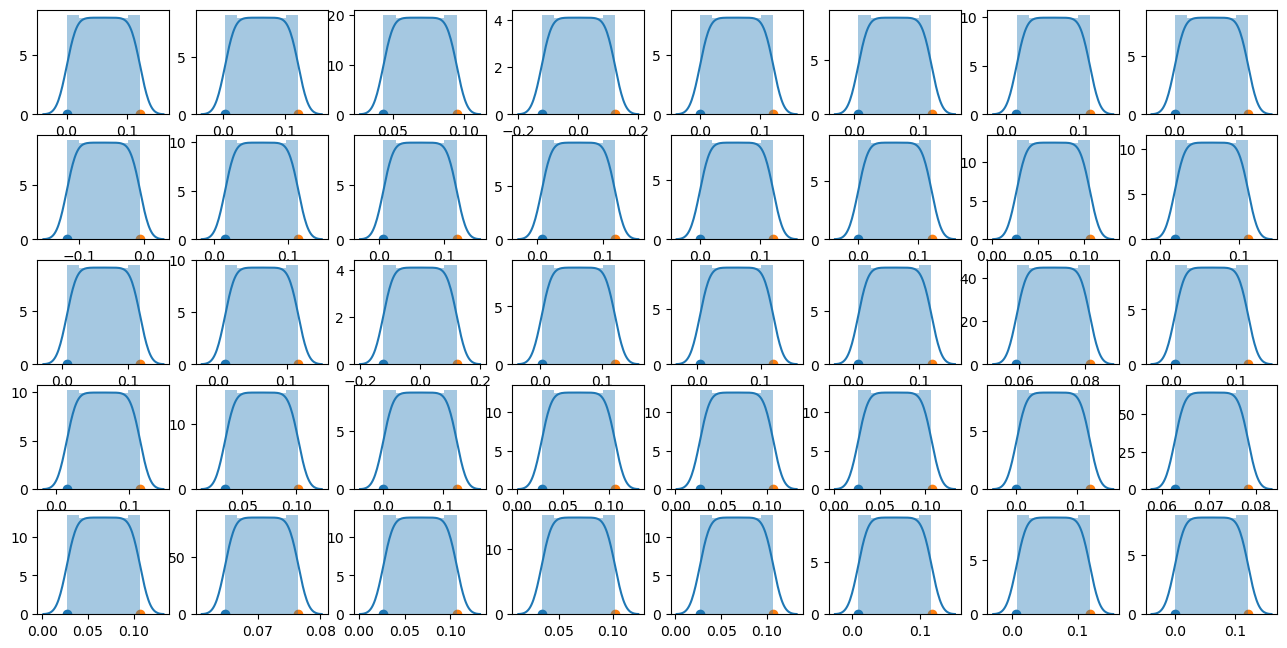

In [59]:
fig,ax = plt.subplots(5,8,figsize=[16,8],dpi=100)

for i in range(40):
    col = i %8
    row = int(np.floor(i/8))
    sn.distplot(x[:,i], ax=ax[row,col])
    ax[row,col].scatter([xlb_single_value_scaled[i]],[0])
    ax[row,col].scatter([xub_single_value_scaled[i]],[0])

In [60]:
len(init_job_list),len(optimized_job_list), x.shape

(200, 0, (200, 40))

# train a surrogate model

2.5 0 (160, 40)
2.5 1 (160, 40)
2.5 2 (160, 40)
2.5 3 (160, 40)
2.5 4 (160, 40)
2.5 0.0675953969185091 (160, 40)


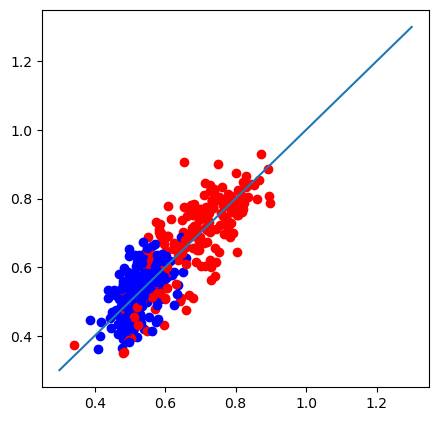

In [61]:
k_fold = 5
tot_sample_size = norm_metric_mean.shape[1]
num_validate_per_k = tot_sample_size/k_fold
num_train_per_k = tot_sample_size - num_validate_per_k

tot_id_list = np.arange(tot_sample_size)

# shuffle the id list
random.shuffle(tot_id_list)

# alpha = 1e-3
# lb = 1e-3
# ub = 1e3
# nu = 2.5

alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 2.5

plt.figure(figsize=[5,5],dpi=100)
for alpha in [alpha]:
    rmse_list = []
    for k in range(k_fold):
#        validate_id_list = np.arange(k*num_validate_per_k,(k+1)*num_validate_per_k).astype(np.int)
        validate_id_list = tot_id_list[int(k*num_validate_per_k):int((k+1)*num_validate_per_k)]
        train_id_list = np.array(list(set(tot_id_list).difference(validate_id_list)))
    #     print(train_id_list, validate_id_list)

        x_train = x[train_id_list, :]
        x_val = x[validate_id_list, :]

        y_train = y[train_id_list, :]
        y_val = y[validate_id_list, :]

        sm_test = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[0], xlb_single_value_scaled, xub_single_value_scaled, alpha=alpha, leng_sb=[lb,ub],nu=nu)
        y_predict = sm_test.predict(x_val)

        rmse_list.append(np.sqrt(pow(y_predict - y_val, 2).mean()))
        print(nu, k, x_train.shape)
        plt.scatter(y_predict.T[0],y_val.T[0],color='r')
        if nOutput == 2:
            plt.scatter(y_predict.T[1],y_val.T[1],color='b')
    print(nu, np.mean(rmse_list), x_train.shape)

plt.plot([0.3,1.3],[0.3,1.3])


# train surrogate model

In [62]:
alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 2.5

sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_single_value_scaled, xub_single_value_scaled,alpha=alpha, leng_sb=[lb,ub], nu=nu)

In [63]:
y_predict,y_std = sm.predict(x,return_std=True)

In [64]:
df_range_sum = pd.DataFrame()

for i_param,param in enumerate(bound_scale_df.index.values):
    y_sim = []
    lb = bound_scale_df['lb'].loc[param]
    ub = bound_scale_df['ub'].loc[param]
    default_list = bound_scale_df['default'].values
    x_sim_list = []
    for j in range(11):
        x = default_list.copy()
        x_sim = lb + (ub-lb)*j/10
        x[i_param] = x_sim
        x_sim_list.append(x_sim)
        y_sim.append(sm.predict(x)[0])
    if nOutput == 2:
        y_sim_df = pd.DataFrame(y_sim,index=x_sim_list, columns=['flow_metric','swe_metric'])
    else:
        y_sim_df = pd.DataFrame(y_sim,index=x_sim_list, columns=['flow_metric'])
    df_range = pd.DataFrame(y_sim_df.max(axis=0) - y_sim_df.min(axis=0), columns=[param])
    df_range_sum = pd.concat([df_range_sum,df_range],axis=1)

In [65]:
df_range_sum = df_range_sum.T
if nOutput == 2:
    df_range_sum['sum'] = df_range_sum['flow_metric'] + df_range_sum['swe_metric']
else:
    df_range_sum['sum'] = df_range_sum['flow_metric']

df_range_sorted = df_range_sum.sort_values('sum',ascending = False)

In [66]:
x_id = np.where(bound_scale_df.index.values==param)[0][0]

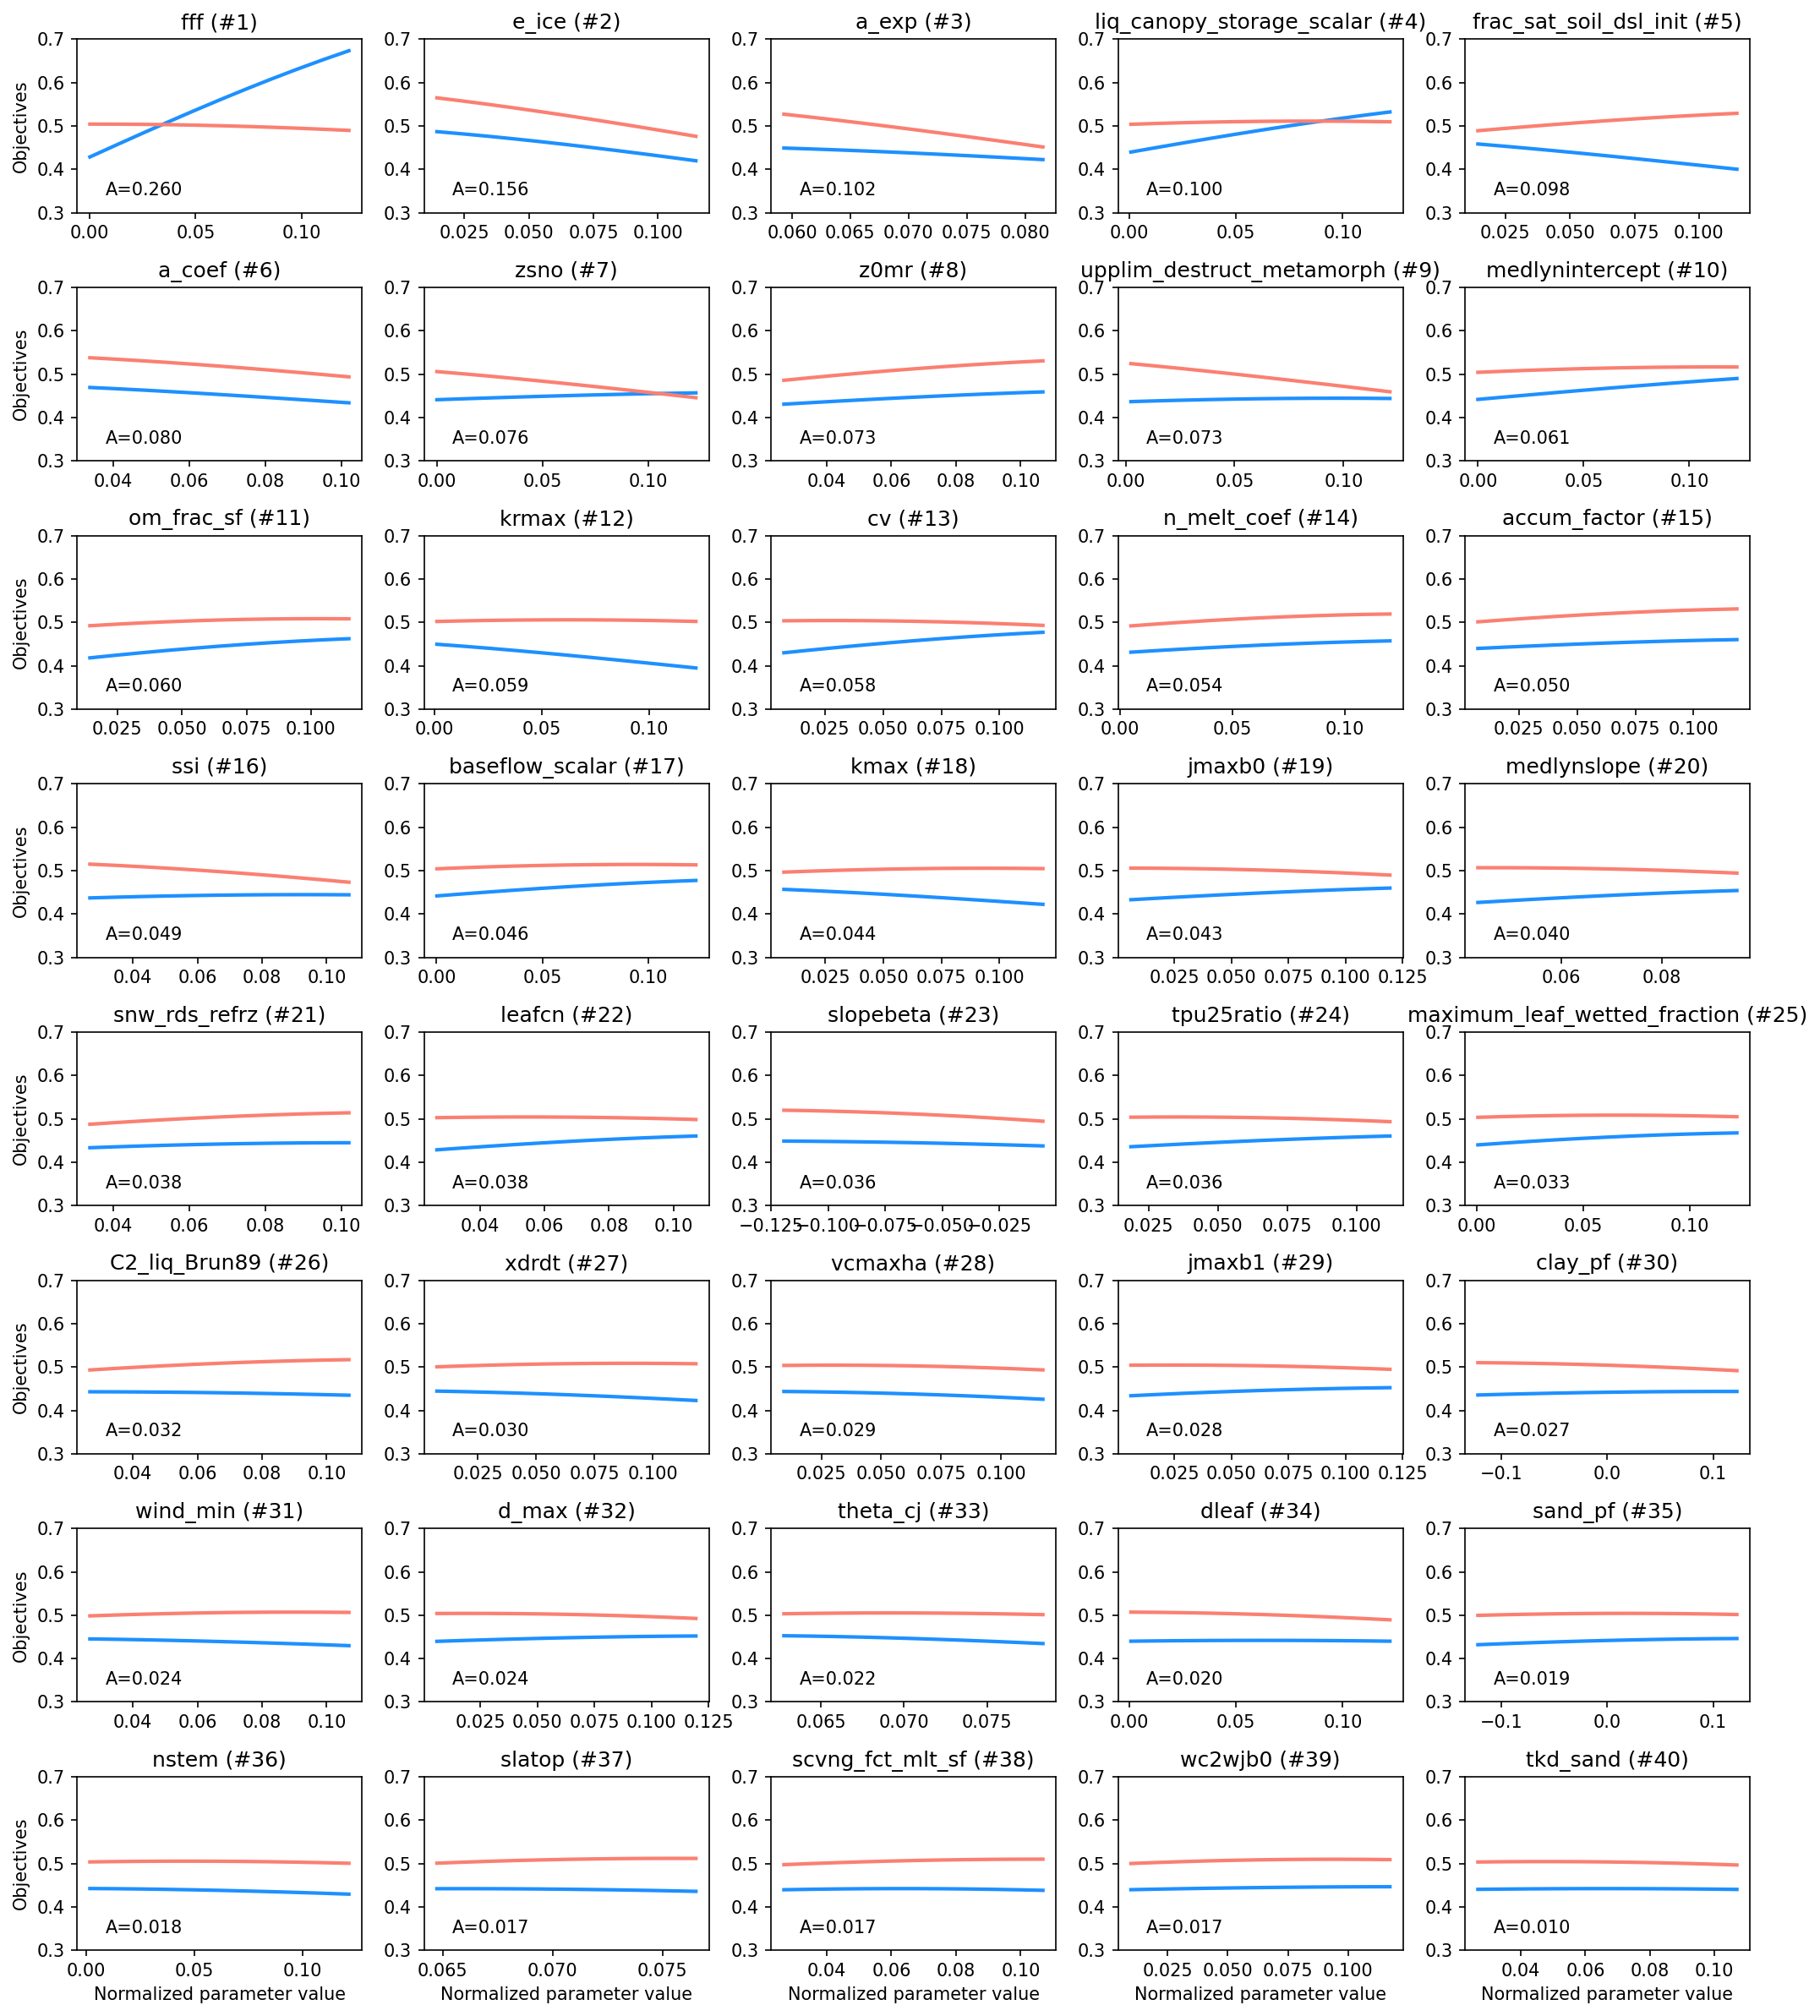

In [67]:
df_range_sum = pd.DataFrame()

fig,ax = plt.subplots(8, 5,figsize=[14,16],dpi=150)
for i_param,param in enumerate(df_range_sorted.index.values):
    y_sim = []
    lb = bound_scale_df['lb'].loc[param]
    ub = bound_scale_df['ub'].loc[param]
    default_list = bound_scale_df['default'].values
    x_sim_list = []
    x_id = np.where(bound_scale_df.index.values==param)[0][0]
    for j in range(11):
        x = default_list.copy()
        x_sim = lb + (ub-lb)*j/10
        x[x_id] = x_sim
        x_sim_list.append(x_sim)
        y_sim.append(sm.predict(x)[0])
    if nOutput == 2:
        y_sim_df = pd.DataFrame(y_sim,index=x_sim_list, columns=['flow_metric','swe_metric'])
    else:
        y_sim_df = pd.DataFrame(y_sim,index=x_sim_list, columns=['flow_metric'])
    df_range = pd.DataFrame(y_sim_df.max(axis=0) - y_sim_df.min(axis=0), columns=[param])
    df_range_sum = pd.concat([df_range_sum,df_range],axis=1)
        
    col = i_param %5
    row = int(np.floor(i_param/5))
    ax[row,col].plot(y_sim_df.index.values,y_sim_df['flow_metric'].values, lw=2, c='dodgerblue')
    if nOutput == 2:
        ax[row,col].plot(y_sim_df.index.values,y_sim_df['swe_metric'].values, lw=2, c='salmon')
    ax[row,col].set_title("%s (#%s)"%(param,i_param+1))
    ax[row,col].set_ylim(0.3,0.7)
    xmin,xmax = ax[row,col].get_xlim()
    ymin,ymax = ax[row,col].get_ylim()
    ax[row,col].text(xmin*0.9+xmax*0.1,ymin*0.9+ymax*0.1,"A=%s"%("%.3f"%(df_range_sorted.loc[param]['sum'])))
    if col == 0:
        ax[row,col].set_ylabel('Objectives')
    if row == 7:
        ax[row,col].set_xlabel('Normalized parameter value')

plt.tight_layout()
# plt.title(basin_sel)

In [68]:
df_range_sorted.to_csv('ppe/ppe_surrogate_model_sensitive_param.%s.csv'%(basin_sel))

# stop here